# Surf's Up 
## Unit 10: Advanced SQL and APIs

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# pd.options.display.max_rows = 3000

# create engine for connections/sessions
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

In [2]:
# build inspector (used throughout)
inspector = inspect(engine)

In [3]:
# gather keys for data
# Base.classes.keys()

## this is functionally the same as
# inspector = inspect(engine)
# inspector.get_table_names()

# ENIGNE RESULTS: measurement, station

In [4]:
# inspect station data (specifically looking for column names...)

# Station_info = inspector.get_columns('station')
# for header in Station_info:
#     print(header['name'])

## STATION RESULTS: id, station, name, latitude, longitude, elevation

In [5]:
# inspect measurement data (specifically looking for column names...)

# Measurement_info = inspector.get_columns('measurement')
# for header in Measurement_info:
#     print(header['name'])

## MEASUREMENT RESULTS: id, station, date, prcp, tobs

In [6]:
# reflect tables into classes
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
session = Session(engine)

In [8]:
conn = engine.connect()

## Precipitation Analysis

In [9]:
# read data into df, convert date from string to usable datetime
# query to retrieve the date and precipitation scores
precipitation_df = pd.read_sql_query('SELECT "date", "prcp" FROM measurement', conn)

In [10]:
# calculate the date 1 year ago from the last data point in the database
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
end = precipitation_df['date'].max()
start = end - dt.timedelta(days=364)

In [11]:
# save the query results as a Pandas DataFrame
year_of_precip = (precipitation_df['date'] >= start) & (precipitation_df['date'] <= end)
twelve_mo_precip_df = precipitation_df.loc[year_of_precip]
# twelve_mo_precip_df.head()

In [12]:
#  and set the index to the date column
#  sort the dataframe by date, .groupby to get TOTAL BY DAY
precip_df = twelve_mo_precip_df.groupby('date')
plotting_precip_df = precip_df.sum()
# plotting_precip_df.head()

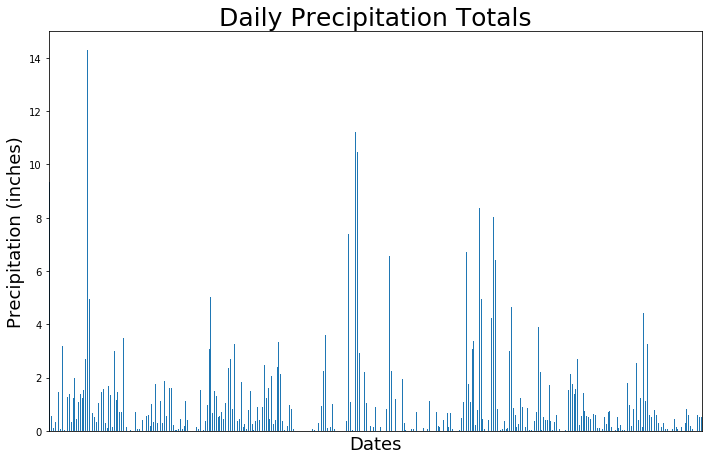

In [13]:
# plot daily precipitation totals from the dataframe

plotting_precip_df.plot(kind='bar', figsize=(10, 6.5))

plt.title('Daily Precipitation Totals', fontsize = 25)
plt.xlabel('Dates', fontsize = 18)
plt.ylabel('Precipitation (inches)', fontsize = 18)
plt.yticks(fontsize = 10)

plt.tick_params(
    axis='x', 
    which='both', 
    bottom=False, 
    top=False, 
    labelbottom=False) 

legend = plt.legend()
legend.remove()

plt.tight_layout()
plt.savefig('Images/Daily Precipitation Totals.png')
plt.show()

# REVISIT: figure out how to put in periodic x-ticks with corresponding labels
# 365 bars is too many for *good* visualization if you are trying to *use* it to make a decision..
# If just for seeing the 'shape' it's fine...

In [14]:
# print summary stats for daily precipitation
plotting_precip_df.describe()

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


## Station Analysis

### Total Number of Stations:

In [15]:
# query for total number of stations
station_count = session.query(Station.name).count()
print(f'There are {station_count} participating stations.')

There are 9 participating stations.


### Stations by Observation Count:

In [16]:
# list stations by observation count in descending order
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == Station.station).\
    order_by(func.count(Measurement.tobs).\
    desc())

for station in station_activity:
    print(station)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


### Station with Most Observations:

In [17]:
station_activity_max = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == Station.station).\
    order_by(func.count(Measurement.tobs).desc()).\
    first()

use_station = station_activity_max[0]
use_name = f'{station_activity_max[1][0:6]}, {station_activity_max[1][-5:-3]}'

print(f'Station: {use_station}')
print(f'Station Name: {use_name}')
print(f'Observation Count: {station_activity_max[2]}')

Station: USC00519281
Station Name: WAIHEE, HI
Observation Count: 2772


### Temperature Analysis of Station with Most Observations:

In [18]:
# using the station id with highest obseration count, calculate min, max, and avg temperature recorded there

station_measurements = session.query(func.min(Measurement.tobs),
                                     func.max(Measurement.tobs),
                                     func.avg(Measurement.tobs)).\
                       filter(Measurement.station == use_station).all()
station_measurements

statement = f'recorded temperature at Station {use_station} in {use_name} is'

print(f'Minimum {statement} {station_measurements[0][0]}.')
print(f'Maximum {statement} {station_measurements[0][1]}.')
print(f'Average {statement} {round(station_measurements[0][2], 1)}.')

Minimum recorded temperature at Station USC00519281 in WAIHEE, HI is 54.0.
Maximum recorded temperature at Station USC00519281 in WAIHEE, HI is 85.0.
Average recorded temperature at Station USC00519281 in WAIHEE, HI is 71.7.


In [19]:
temperature_df = pd.read_sql_query('SELECT "station", "date", "tobs" FROM measurement', conn)

In [20]:
temperature_df['date'] = pd.to_datetime(temperature_df['date'])
end = temperature_df['date'].max()
start = end - dt.timedelta(days=364)
# temperature_df

In [21]:
# query the last 12 months (=365 days) of temp obs for this station and plot as a histogram
year_of_temp = (temperature_df['date'] >= start)
twelve_mo_temp_df = temperature_df.loc[year_of_temp]
# twelve_mo_temp_df.head()

In [22]:
# use the station with the highest number of temperature observations
specific_temps = (temperature_df['station'] == 'USC00519281')
USC00519281_temps_df = temperature_df[specific_temps]
# USC00519281_temps_df.head()

# validate session.query for min/max/avg via pandas...
# .count() = 2772 | .min() = 54 | .max() = 85 | .mean() = 71.66 

In [23]:
# need to trim USC00519281_temps_df for just the last 365 days of observations
usc_81_year = (USC00519281_temps_df['date'] >= start)
plotting_temp_df = USC00519281_temps_df.loc[usc_81_year]
# plotting_temp_df.head()

# .count() = 351 | .min() = 59 | .max() = 83 | .mean() = 73.2 

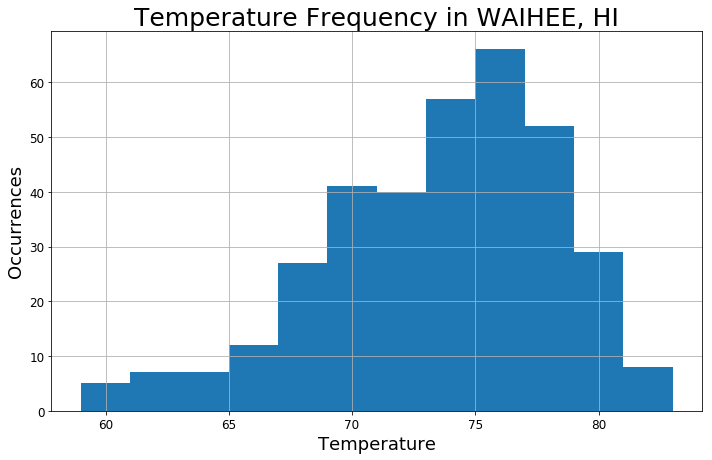

In [24]:
# plot to histogram
plotting_temp_df.hist(column = 'tobs', bins = 12, figsize=(10, 6.5))
                      
plt.title(f'Temperature Frequency in {use_name}', fontsize = 25)
plt.xlabel('Temperature', fontsize = 18)
plt.ylabel('Occurrences', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout()
plt.savefig('Images/Temperature Frequency.png')
plt.show()

## Evaluating Trip Dates

In [25]:
# `calc_temps` accepts start and end dates in the format '%Y-%m-%d' 
# it returns the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

### Calculating minimum, average, and maximum temperatures over selected dates:

In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip = calc_temps('2017-02-09', '2017-02-19')

print(f'The anticipated low temperature over my travel dates should be around {my_trip[0][0]}.')
print(f'The average expected temperature over my travel dates should be around {round(my_trip[0][1], 1)}.')
print(f'The expected high temperature over my travel dates should be around {my_trip[0][2]}.')

The anticipated low temperature over my travel dates should be around 59.0.
The average expected temperature over my travel dates should be around 70.6.
The expected high temperature over my travel dates should be around 80.0.


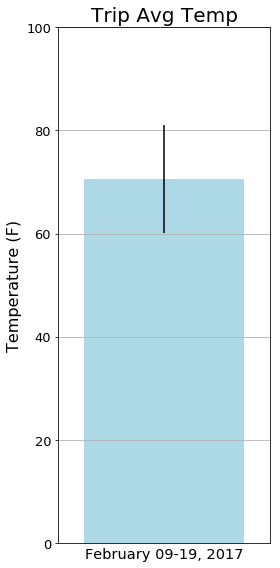

In [27]:
# plot results of query as a bar chart, Title: "Trip Avg Temp", y = avg temp, yerr = end to end (tmax-tmin) value
# save and display image

my_trip_avg = round(my_trip[0][1], 1)

plt.figure(figsize=(4,8))
plt.bar(0, my_trip_avg, color = "lightblue", yerr = ((my_trip[0][2])-(my_trip[0][0]))/2)

plt.title('Trip Avg Temp', fontsize = 20)
plt.grid(which = 'major', axis = 'y')

plt.xlabel('February 09-19, 2017', fontsize = 14.5)
plt.xlim(-.53,.53)
plt.xticks(ticks=[])

plt.ylabel('Temperature (F)', fontsize = 16)
plt.ylim(0,100)
plt.yticks(fontsize = 13)

plt.tight_layout()
plt.savefig('Images/Trip Avg Temp.png')
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
# save and display image
plt.savefig('Images/Daily Normals.png')
plt.show()